In [1]:
import numpy as np
import scipy
import scipy.stats as sps
from scipy.stats import gmean
import scipy.optimize as spopt
import matplotlib.pyplot as plt

# Defining functions to use


In [2]:
def sigmas_to_p(sigval):
    nd = sps.norm(0., 1.)
    return 2.*nd.sf(sigval)


def histrebin(mininbin,counts,edges): 
    # rebins a histogram so there are at least mininbin counts per bin

    edges_new=np.zeros(1)
    counts_new=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges_new[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  
            # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: 
                # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts_new[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts_new=np.append(counts_new,countsum)
            edges_new=np.append(edges_new,edges[i])
            countsum=0        

    return counts_new, edges_new


def model_int_cf(ecent, ebins, model, *parm): 
    # General function for integrating the input model over energy
    # bins ebins, including also a dummy energy bin centres input ecent 
    # (which must match the number of bins in array length)
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

def plgauss_model(value, parm):
    pl_norm = parm[0]  # here the function given means that the normalisation corresponds to that at a value 1.0
    pl_index = parm[1]
    line_en = parm[2]
    line_sig = parm[3]
    line_norm = parm[4]
    # The line is a Gaussian shape with a normalisation equal to the number of counts in the line
    lineflux = np.exp(-0.5*np.power((value - line_en)/line_sig, 2.))/(line_sig*np.sqrt(2.*np.pi))
    return pl_norm * np.power(value,pl_index) + line_norm * lineflux


def gauss_model(value, parm):
    line_en1 = parm[0]
    line_sig1 = parm[1]
    line_norm1 = parm[2]
    backround= parm[3]
    # The line is a Gaussian shape with a normalisation equal to the number of counts in the line
    lineflux1 = np.exp(-0.5*np.power((value - line_en1)/line_sig1, 2.))/(line_sig1*np.sqrt(2.*np.pi))
    return line_norm1 * lineflux1 + backround

def double_gauss_model(value, parm):
    line_en1 = parm[0]
    line_sig1 = parm[1]
    line_norm1 = parm[2]
    line_en2 = parm[3]
    line_sig2 = parm[4]
    line_norm2 = parm[5]
    backround= parm[6]
    # The line is a Gaussian shape with a normalisation equal to the number of counts in the line
    lineflux1 = np.exp(-0.5*np.power((value - line_en1)/line_sig1, 2.))/(line_sig1*np.sqrt(2.*np.pi))
    lineflux2 = np.exp(-0.5*np.power((value - line_en2)/line_sig2, 2.))/(line_sig2*np.sqrt(2.*np.pi))
    return line_norm1 * lineflux1 + line_norm2 * lineflux2 + backround

def lin_model(value, parm):
    return parm[0] + parm[1]*value

def plot_spec_model(energies,cdens,cdens_err,cdens_model,ebins):
    
    bwidths = ebins[1:]-ebins[:-1]
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
    dummy_data = (ebins[1:]+ebins[:-1])/2
    model_hist, edges, patches = ax1.hist(dummy_data, bins=ebins, weights=cdens_model, 
                                      density=False, histtype='step')
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='o')
    ax2.set_xlabel("Channel #", fontsize=16)
    ax1.set_ylabel("Counts", fontsize=14)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(ebins[0],ebins[-1]) # Strictly speaking we should only show the energy range where data is sampled, 
    # to avoid impression from model that the flux suddenly drops at the boundaries.
    plt.show()
    
def grid_search2d_nmchisq(aval,bval,aindex,bindex,parm,model,xval,yval,dy):
    # aval is the 1-D grid of parameter values searched over, parm is the array of the other (fitted) 
    # parameter's starting values, while aindex gives the location to insert the parameter searched over into 
    # the parameter array for use in the log-likelihood function being evaluated
    llval = np.zeros([len(aval),len(bval)])
    i = -1
    for a in aval:
        i = i + 1
        j = -1
        for b in bval:
            j = j + 1
            llfunc = lambda parm, model, xval, yval, dy: ChiSq(
                np.insert(np.insert(parm,aindex,a),bindex,b),model, xval, yval, dy)
            result = spopt.minimize(llfunc, parm, args=(model, xval, yval, dy), method='Nelder-Mead')
            llval[i,j] = result.fun
    return llval    # outputs the log-likelihood values for the parameter values that are searched over


def grid_search_nmchisq(aval,aindex,parm,model,xval,yval,dy):
    # aval is the 1-D grid of parameter values searched over, parm is the array of the other (fitted) 
    # parameter's starting values, while aindex gives the location to insert the parameter searched over into 
    # the parameter array for use in the log-likelihood function being evaluated
    llval = np.zeros(len(aval))
    i = -1
    for a in aval:
        i = i + 1
        llfunc = lambda parm, model, xval, yval, dy: ChiSq(np.insert(parm,aindex,a), model, xval, yval, dy)
        result = spopt.minimize(llfunc, parm, args=(model, xval, yval, dy), method='Nelder-Mead')
        llval[i] = result.fun
    return llval    # outputs the log-likelihood values for the parameter values that are searched over


def grid_errors(best_a,llmin,aval,llval,dll):
    # Estimates errors corresponding to change in the log-likelihood dll (or weighted least squares) - 
    # quite crude, could improve with interpolation between the values of a which cross the required dll.
    # Requires best-fitting MLE for parameter searched over and it's log-likelihood statistic, the arrays of
    # parameter searched over and corresponding best-fit log-likelihoods for those parameter values,
    # and the delta-ll.
    a_cimin = 1.e12
    a_cimax = -1.e12
    i = -1
    for a in aval:
        i = i + 1
        if llval[i]-llmin <= dll:
            if a < best_a and a < a_cimin:
                a_cimin = a
            if a > best_a and a > a_cimax:
                a_cimax = a
    return np.array([a_cimin-best_a,a_cimax-best_a]) # output [-error,+error]

def ChiSq_Integ(parm, my_model, ebins, yval, dy): 
    # the weighted least-squares for an array of upper and lower bin edges
    # (xval1 and xval2) fitted with the integral over the bin of the model my_model
    i = 0
    ymod = np.zeros(len(yval))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: my_model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1

    return sum(pow((yval-ymod)/dy,2))

def LogLikelihood_Pois_Integ(parm, my_model, ebins, yval): 
    # the -ve Poisson log-likelihood for an array 
    # of bin edges, fitted with the integral over the bin of the generic model my_fit_model.  
    # Input yval must be counts and not counts per unit x-value
    i = 0
    ymod = np.zeros(len(yval))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: my_model(x, parm),ebins[i],ebins[i+1])
        # we don't normalise by bin width since the rate parameter is set by the model and needs to be 
        # in counts per bin
        i=i+1
        
    pd = sps.poisson(ymod) #we define our Poisson distribution

    return -sum(np.log(pd.pmf(yval)))

    
def LogLikelihood(parm, model, xval, yval, dy): # the -ve log-likelihood
    ymod = model(xval, parm)  #We define our 'physical model' separately
    nd = sps.norm(ymod, dy) #we define our normal distribution
    return -sum(nd.logpdf(yval)) # The nd.logpdf may be more accurate than log(nd.pdf) for v. small values

def ChiSq(parm, model, xval, yval, dy): # the weighted least-squares
    ymod = model(xval, parm)
    return sum(pow((yval-ymod)/dy,2))

# Data Calibration



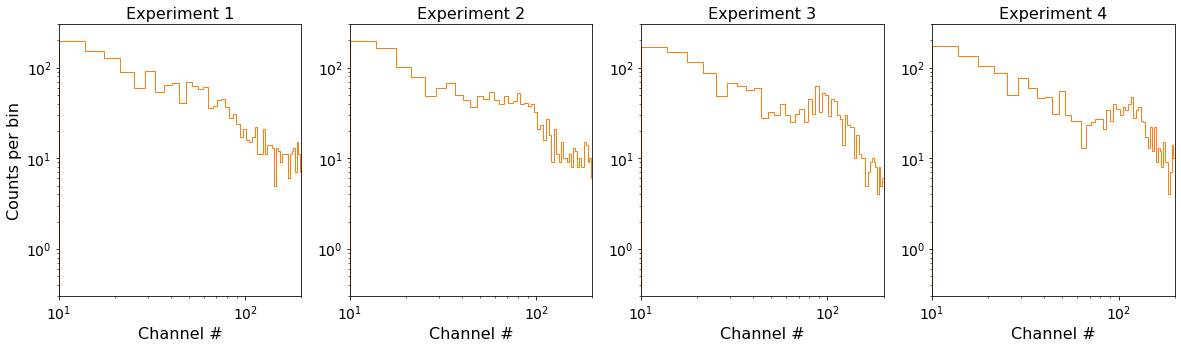

In [3]:
cal_data = np.genfromtxt('Giorgos_Zervas_Koukogias_CAL.dat')

exp1=cal_data[cal_data[:,0]==1.]
exp2=cal_data[cal_data[:,0]==2.]
exp3=cal_data[cal_data[:,0]==3.]
exp4=cal_data[cal_data[:,0]==4.]



#Defining and plotting histograms of the initial data

nbins = 50
emin=10.0
emax=200.0
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,5))
counts1, edges1, patches1 = ax1.hist(exp1, bins=50, range=[emin,emax], density=False, histtype='step', fill=False)
counts2, edges2, patches2 = ax2.hist(exp2, bins=50, range=[emin,emax], density=False, histtype='step', fill=False)
counts3, edges3, patches3 = ax3.hist(exp3, bins=50, range=[emin,emax], density=False, histtype='step', fill=False)
counts4, edges4, patches4 = ax4.hist(exp4, bins=50, range=[emin,emax], density=False, histtype='step', fill=False)
ax1.set_title('Experiment 1',fontsize=16)
ax2.set_title('Experiment 2',fontsize=16)
ax3.set_title('Experiment 3',fontsize=16)
ax4.set_title('Experiment 4',fontsize=16)

ax1.set_ylabel("Counts per bin", fontsize=16)

for ax in (ax1,ax2,ax3,ax4):
    ax.set_xlabel("Channel #", fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(0.3,300.0)
    ax.set_xlim(10.0,200.0)
    ax.tick_params(labelsize=14)


plt.show()
#print(edges1)

In [4]:

### Now we make our unbinned histogram.  We can keep the initial number of bins relatively large.
nbins = 50
counts1, edges1 = np.histogram(exp1, bins=nbins, range=[emin,emax], density=False)
counts2, edges2 = np.histogram(exp2, bins=nbins, range=[emin,emax], density=False)
counts3, edges3 = np.histogram(exp3, bins=nbins, range=[emin,emax], density=False)
counts4, edges4 = np.histogram(exp4, bins=nbins, range=[emin,emax], density=False)

### And now we use our new function to rebin so there are at least mincounts counts per bin:
mincounts = 20 # Here we set it to our minimum requirement of 20
counts1_new, edges1_new = histrebin(mincounts,counts1,edges1)
counts2_new, edges2_new = histrebin(mincounts,counts2,edges2)
counts3_new, edges3_new = histrebin(mincounts,counts3,edges3)
counts4_new, edges4_new = histrebin(mincounts,counts4,edges4)

#print(edges2_new)


In [5]:
bwidths1 = np.diff(edges1_new) # calculates the width of each bin
bwidths2= np.diff(edges2_new)
bwidths3 = np.diff(edges3_new)
bwidths4 = np.diff(edges4_new)
cdens1 = counts1_new/bwidths1 # determines the count densities
cdens2 = counts2_new/bwidths2
cdens3 = counts3_new/bwidths3
cdens4 = counts4_new/bwidths4
cdens_err1 = np.sqrt(counts1_new)/bwidths1
cdens_err2 = np.sqrt(counts2_new)/bwidths2
cdens_err3 = np.sqrt(counts3_new)/bwidths3
cdens_err4 = np.sqrt(counts4_new)/bwidths4
# calculate the errors: remember the error is based on the counts, 
# not the count density, so we have to also apply the same normalisation.

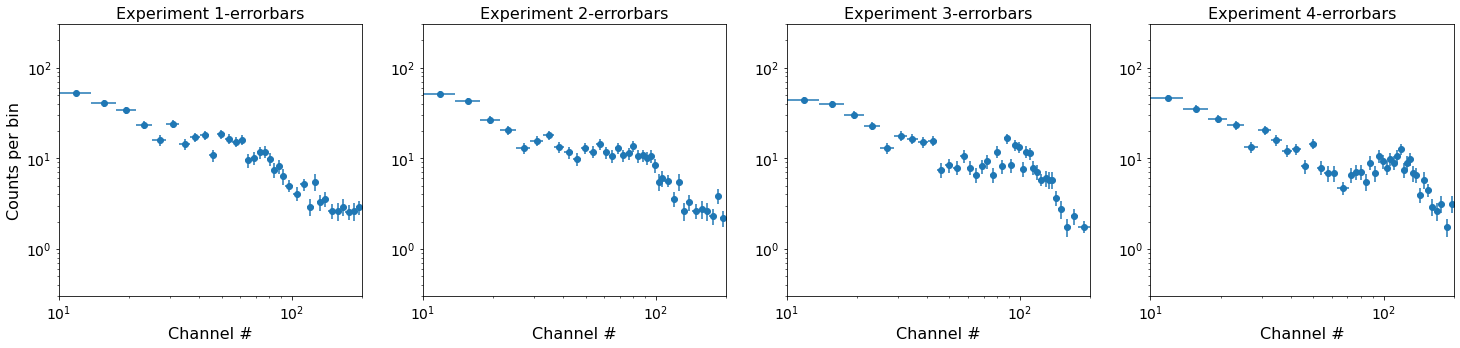

In [6]:
channel1 = (edges1_new[:-1]+edges1_new[1:])/2
channel2 = (edges2_new[:-1]+edges2_new[1:])/2
channel3 = (edges3_new[:-1]+edges3_new[1:])/2
channel4 = (edges4_new[:-1]+edges4_new[1:])/2


#making a plot of the rebinned histograms with error bars defined above

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,5))
ax1.errorbar(channel1, cdens1, xerr=bwidths1/2., yerr=cdens_err1, fmt='o')
ax2.errorbar(channel2, cdens2, xerr=bwidths2/2., yerr=cdens_err2, fmt='o')
ax3.errorbar(channel3, cdens3, xerr=bwidths3/2., yerr=cdens_err3, fmt='o')
ax4.errorbar(channel4, cdens4, xerr=bwidths4/2., yerr=cdens_err4, fmt='o')
ax1.set_title('Experiment 1-errorbars',fontsize=16)
ax2.set_title('Experiment 2-errorbars',fontsize=16)
ax3.set_title('Experiment 3-errorbars',fontsize=16)
ax4.set_title('Experiment 4-errorbars',fontsize=16)

ax1.set_ylabel("Counts per bin", fontsize=16)

for ax in (ax1,ax2,ax3,ax4):
    ax.set_xlabel("Channel #", fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(0.3,300.0)
    ax.set_xlim(10.0,200.0)
    ax.tick_params(labelsize=14)

# Plotting the distribution of errors to use in the curve_fit model 
# We would like normally distributed errors for this


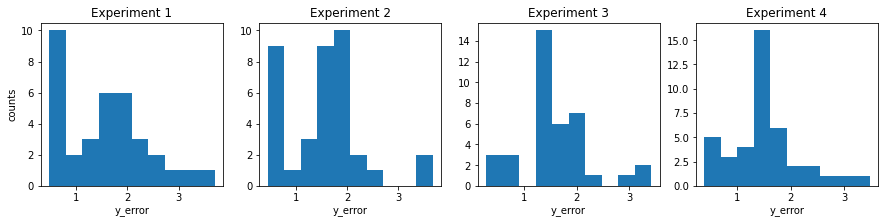

In [7]:
fig, (ax1,ax2,ax3,ax4)=plt.subplots(1,4, figsize=(15,3))
ax1.hist(cdens_err1)
ax2.hist(cdens_err2)
ax3.hist(cdens_err3)
ax4.hist(cdens_err4)
ax1.set_ylabel('counts')
ax1.set_title('Experiment 1')
ax1.set_xlabel('y_error')
ax2.set_title('Experiment 2')
ax2.set_xlabel('y_error')
ax3.set_title('Experiment 3')
ax3.set_xlabel('y_error')
ax4.set_title('Experiment 4')
ax4.set_xlabel('y_error')
plt.show()

# Fitting a power-law + Gaussian model for our data

In [59]:
p1 = [1000.0, -1.15, 70.0, 20.0, 200.0]
p2 = [1000.0, -1.15, 90.0, 20.0, 200.0]
p3 = [1000.0, -1.15, 110.0, 20.0, 200.0]
p4 = [1000.0, -1.15, 130.0, 20.0, 200.0]
model = plgauss_model

channels=[channel1,channel2,channel3,channel4]
new_edges=[edges1_new,edges2_new,edges3_new,edges4_new,]
cdensities=[cdens1,cdens2,cdens3,cdens4]
cdens_errs=[cdens_err1,cdens_err2,cdens_err3,cdens_err4]
p=[p1,p2,p3,p4]

ml_cfpars=[]
ml_cfcovar=[]
best_model=[]
minchisq=[]
err=[]
cf_pars=[]
cf_covar=[]
gof=[]

#looping for each experiment to apply curve_fit and estimate minchisq
for i in range(4):
    ecent=channels[i]
    ebins=new_edges[i]
    edens=cdensities[i]
    parms=p[i]
    
    
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda ecent, *parm: model_int_cf(ecent, ebins, model, *parm),
                                        ecent, edens, parms, sigma=cdens_errs[i])
    
    cf_pars.append(ml_cfpars)
    cf_covar.append(ml_cfcovar)
    best_model.append(model_int_cf(ecent, ebins, model, *ml_cfpars))
    minchisq.append(np.sum(((edens - best_model[i])/cdens_errs[i])**2.))
    err.append(np.sqrt(np.diag(ml_cfcovar)))
    gof.append(scipy.stats.chi2.sf(minchisq[i],df=(len(edens)-len(parms))))
    
    
for i in range(4):
    print("Normalisation value for experiment "+ str(i+1) + ':' + str(cf_pars[i][0]) + " +/- " + str(err[i][0]))
    print("Power-law index for experiment  "+ str(i+1) + ':' + str(cf_pars[i][1]) + " +/- " + str(err[i][1]))
    print("Line channel for experiment  "+ str(i+1) + ':' + str(cf_pars[i][2]) + " +/- " + str(err[i][2]))
    print("Line width (sigma) for experiment  "+ str(i+1) + ':' + str(cf_pars[i][3]) + " +/- " + str(err[i][3]))
    print("Line normalisation for experiment "+ str(i+1) + ':' + str(cf_pars[i][4]) + " +/- " + str(err[i][4]))
    print("Minimum Chi-squared for experiment  "+ str(i+1) + ':'  + str(minchisq[i]) + " for " + str(len(edens)-len(p[i])) + " d.o.f.")
    print("The goodness of fit for experiment : "+ str(i+1) + ':' + str(gof[i]))
    print('##############################################################################################')
    print('##############################################################################################')


Normalisation value for experiment 1:838.7911059440813 +/- 124.52670445950297
Power-law index for experiment  1:-1.1257060989761618 +/- 0.04030965947022078
Line channel for experiment  1:61.46937743945373 +/- 3.809184572960166
Line width (sigma) for experiment  1:16.50075979028812 +/- 3.9610708760557607
Line normalisation for experiment 1:222.88789948095516 +/- 57.45323622787871
Minimum Chi-squared for experiment  1:47.69635584243382 for 36 d.o.f.
The goodness of fit is for experiment : 1:0.021252858891849115
##############################################################################################
##############################################################################################
Normalisation value for experiment 2:798.5089762212958 +/- 119.99336708222809
Power-law index for experiment  2:-1.1342815474116166 +/- 0.04359647114646049
Line channel for experiment  2:79.19791922370062 +/- 2.6447012891090256
Line width (sigma) for experiment  2:18.519874471795667 +/- 2.85821

# Now plot the data and model

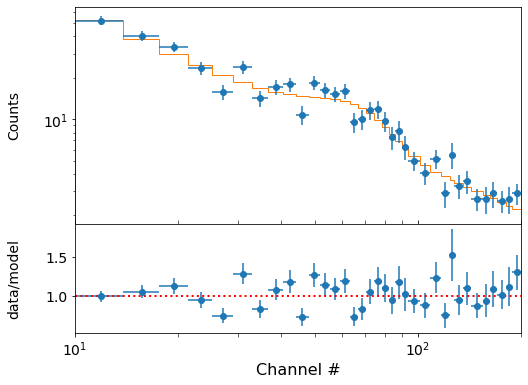

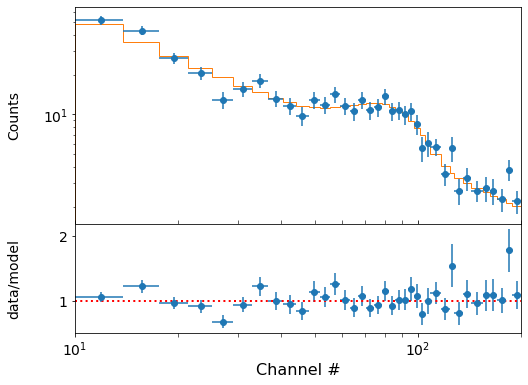

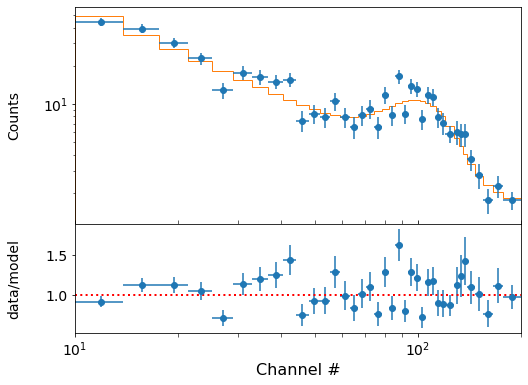

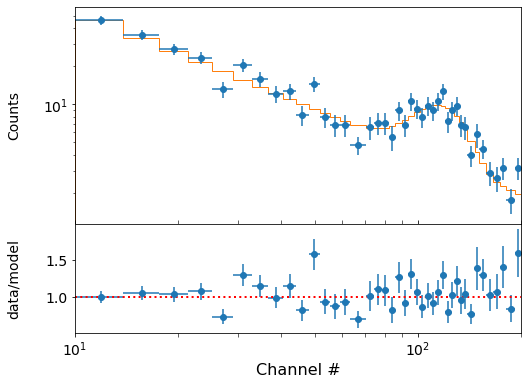

In [9]:
for i in range(4):
    plot_spec_model(channels[i],cdensities[i],cdens_errs[i],best_model[i],new_edges[i])


# Using all of the data approach for the estimation of k
# Taking the centroid value from each model vs the given centroid energy in the sheet
# Then fitting a linear function to determine k 


The obtained k(gradient) coefficient is  1.124838038972981


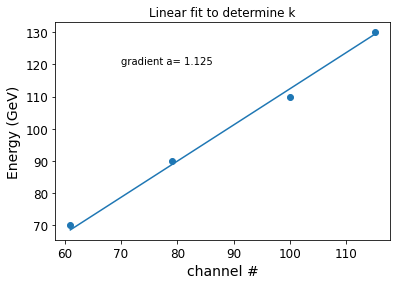

In [10]:
x=np.array([int(cf_pars[0][2]),int(cf_pars[1][2]),int(cf_pars[2][2]),int(cf_pars[3][2])]) #our model parameters
y=[70,90,110,130] #the given parameters for energy

func = lambda x, a: x*a   #the linear fit 
r2, pcov = spopt.curve_fit(func, x,y, p0=(0))



print("The obtained k(gradient) coefficient is ",r2[0])
plt.figure()
plt.scatter(x,y)
plt.plot(x,r2[0]*x)
plt.xlabel("channel #", fontsize=14)
plt.ylabel("Energy (GeV)", fontsize=14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.text(70,120,'gradient a= %a' %round(r2[0],3))
plt.title('Linear fit to determine k')
plt.show()


# Plotting the chisquared values for each parameter

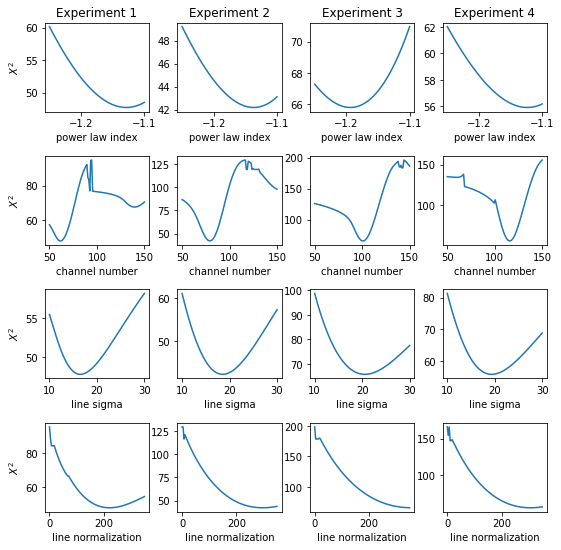

In [11]:
p=[p1,p2,p3,p4]
channel=[channel1,channel2,channel3,channel4]
edges_new=[edges1_new,edges2_new,edges3_new,edges4_new]
cdensity=[cdens1,cdens2,cdens3,cdens4]
cdensity_err=[cdens_err1,cdens_err2,cdens_err3,cdens_err4]

pl_indexchisq=[]
c_numberchisq=[]
c_sigmachisq=[]
c_normchisq=[]



for i in range(4):
    xval=channel[i]
    yval=cdensity[i]
    dy=cdensity_err[i]
    model=plgauss_model
    pl_indexval=np.linspace(-1.25,-1.10,100)
    c_numberval=np.linspace(50,150,100)
    c_sigmaval=np.linspace(10,30,100)
    c_normval=np.linspace(0,350,100)
   
    parm1=p[i].copy()
    parm11=parm1.pop(1)
    pl_indexchisq.append(grid_search_nmchisq(pl_indexval,1,parm1,model,xval,yval,dy))
    
    parm2=p[i].copy()
    parm22=parm2.pop(2)
    c_numberchisq.append(grid_search_nmchisq(c_numberval,2,parm2,model,xval,yval,dy))
    
    parm3=p[i].copy()
    parm33=parm3.pop(3)
    
    c_sigmachisq.append(grid_search_nmchisq(c_sigmaval,3,parm3,model,xval,yval,dy))
    
    parm4=p[i].copy()
    parm44=parm4.pop(4)
    c_normchisq.append(grid_search_nmchisq(c_normval,4,parm4,model,xval,yval,dy))

ndims=4
labels = ['Experiment 1','Experiment 2','Experiment 3','Experiment 4']
fig, axes = plt.subplots(ndims,ndims,figsize=(9,9))
fig.subplots_adjust(wspace=0.27,hspace=0.5)
for i in range(ndims): 
    for j in range(ndims):
        if i==0:
            axes[i,j].plot(pl_indexval,pl_indexchisq[j])
            axes[i,j].set_title(labels[j])
            axes[i,j].set_xlabel('power law index',fontsize=10)
        elif i==1:
            axes[i,j].plot(c_numberval,c_numberchisq[j])
            axes[i,j].set_xlabel('channel number',fontsize=10)
        elif i==2:
            axes[i,j].plot(c_sigmaval,c_sigmachisq[j])
            axes[i,j].set_xlabel('line sigma',fontsize=10)
        elif i==3:
            axes[i,j].plot(c_normval,c_normchisq[j])
            axes[i,j].set_xlabel('line normalization',fontsize=10)
        
        if j == 0:
            axes[i,j].set_ylabel("$X^{2}$",fontsize=10)   
        
plt.show()
      

# Using a brute force approach to find the errors from each parameter estimated using the curve fit
## Fit to find the MLEs and then return the errors from the grid search:

In [61]:

result=[]
mlval=[]
pl_index_mle=[]
c_number_mle=[]
c_sigma_mle=[]
c_norm_mle=[]

for i in range(4):
    xval=channel[i]
    yval=cdensity[i]
    dy=cdensity_err[i]
    model=plgauss_model    
    parm = p[i]
    result=( spopt.minimize(ChiSq_Integ, parm, args=(model,xval,yval,dy), method="Nelder-Mead"))
    par1, par2, par3, par4, par5 = result["x"]
    res = result["fun"]
    mlval.append(res)
    pl_index_mle.append(par2)
    c_number_mle.append(par3)
    c_sigma_mle.append(par4)
    c_norm_mle.append(par5)

    
    
for i in range(4):
    print("Power-law index for experiment  ", i+1,':', pl_index_mle[i],"+",grid_errors(pl_index_mle[i],mlval[i],pl_indexval,pl_indexchisq[i],dll=1.0))
    print("Line channel for experiment  ", i+1,':', c_number_mle[i],"+",grid_errors(c_number_mle[i],mlval[i],c_numberval,c_numberchisq[i],dll=1.0))
    print("Line width for experiment  ", i+1,':', c_sigma_mle[i],"+",grid_errors(c_sigma_mle[i],mlval[i],c_sigmaval,c_sigmachisq[i],dll=1.0))
    print("Line normalization for experiment  ", i+1,':', c_norm_mle[i],"+",grid_errors(c_norm_mle[i],mlval[i],c_normval,c_normchisq[i],dll=1.0))
    print('##############################################################################################')
    print('##############################################################################################')

Power-law index for experiment   1 : -1.186570228513367 + [-0.06342977  0.08657023]
Line channel for experiment   1 : 64.43413873375079 + [-14.43413873  85.56586127]
Line width for experiment   1 : 16.508953881206402 + [-6.50895388 13.49104612]
Line normalization for experiment   1 : 213.13879921449396 + [-184.85597093  136.86120079]
##############################################################################################
##############################################################################################
Power-law index for experiment   2 : -1.185886798337977 + [-0.0641132  0.0858868]
Line channel for experiment   2 : 81.86366751083295 + [-17.72225337   9.5504739 ]
Line width for experiment   2 : 18.584156830049636 + [-8.58415683 11.41584317]
Line normalization for experiment   2 : 292.0381137706754 + [-185.97750771   57.96188623]
##############################################################################################
##############################################

# Now to find correlation between errors for each experiment

Spearman's rho and p-value: [-0.6243792196405389, 0.987094221092752, 0.6007999437702634] [0.3756207803594611, 0.012905778907247978, 0.39920005622973664]


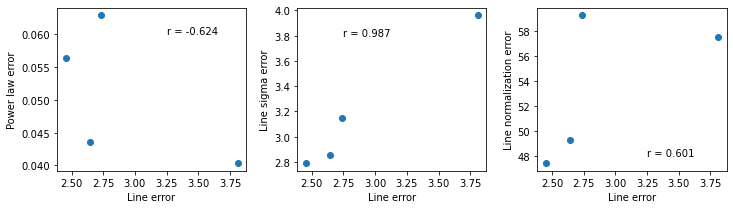

In [13]:
#Now to find correlation between errors for each experiment

#merging curve fit errors(from the covariance matrix) for each experiment into 4 lists(1 for each parameter error)
#I will compare error correlations focusing on the line error, as it is the most important
cf_line_errs=[err[0][2],err[1][2],err[2][2],err[3][2]]
cf_pl_errs=[err[0][1],err[1][1],err[2][1],err[3][1]]
cf_sigma_errs=[err[0][3],err[1][3],err[2][3],err[3][3]]
cf_norm_errs=[err[0][4],err[1][4],err[2][4],err[3][4]]


#checking for correlation using spearman
#there's a bias here, since I use data from different experiments (violation of i.i.d)
#but since all of them use the same model and same parameters for fitting , I am willing to go for it

rcor=[]
rpval=[]
for i in range(3):
    y=[cf_pl_errs,cf_sigma_errs,cf_norm_errs]
    
    x=cf_line_errs
    (r, pval) = sps.pearsonr(x,y[i])
    rcor.append(r) 
    rpval.append(pval)
print("Spearman's rho and p-value:",rcor, rpval)


fig, (ax1,ax2,ax3)=plt.subplots(1,3, figsize=(12,3))
fig.subplots_adjust(wspace=0.27)

ax1.scatter(cf_line_errs,cf_pl_errs)
ax2.scatter(cf_line_errs,cf_sigma_errs)
ax3.scatter(cf_line_errs,cf_norm_errs)
ax1.set_xlabel('Line error')
ax2.set_xlabel('Line error')
ax3.set_xlabel('Line error')
ax1.set_ylabel('Power law error')
ax2.set_ylabel('Line sigma error')
ax3.set_ylabel('Line normalization error')
ax1.text(3.25,0.060,'r = %r' %round(rcor[0],3) )
ax2.text(2.75,3.8,'r = %r' %round(rcor[1],3) )
ax3.text(3.25,48,'r = %r' %round(rcor[2],3) )
plt.show()

# Here I fit linear models to the errors where correlation is evident

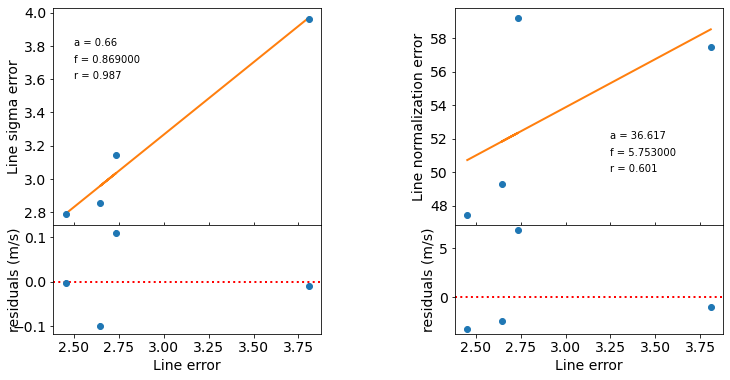

In [14]:
#having said that, I skip the power law error case, since the evidence points
#to anti-correlation, or even power law like correlation



result=[]
mlval=[]
a_mle=[]
b_mle=[]
parm1=[0.9, 0.1]
parm2=[30, 5]
parm=[parm1,parm2]
xval=np.array(cf_line_errs)
yval=np.array([cf_sigma_errs,cf_norm_errs])
#print(cf_line_errs)

dy=np.full(4,6.3e-3)
model=lin_model

for i in range(2):
    
        
    result=( spopt.minimize(ChiSq, parm[i], args=(model,xval,yval[i],dy), method="Nelder-Mead"))
    par1, par2 = result["x"]
    res = result["fun"]
    mlval.append(res)
    a_mle.append(par1)
    b_mle.append(par2)


fig, axes = plt.subplots(2,2, figsize=(12,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
fig.subplots_adjust(wspace=0.5, hspace=0)
axes[0,0].errorbar(xval, yval[0], yerr=np.full(4,6.3e-3), marker="o", linestyle="")
axes[0,1].errorbar(xval, cf_norm_errs, yerr=np.full(4,6.3e-3), marker="o", linestyle="")
axes[0,0].plot(xval, lin_model(xval,[a_mle[0], b_mle[0]]), lw=2)
axes[0,1].plot(xval, lin_model(xval,[a_mle[1], b_mle[1]]), lw=2)
axes[0,0].set_ylabel("Line sigma error", fontsize=14)
axes[0,1].set_ylabel("Line normalization error", fontsize=14)
axes[0,0].tick_params(labelsize=14)
axes[0,1].tick_params(labelsize=14)
axes[1,0].errorbar(xval, yval[0]-lin_model(xval,[a_mle[0], b_mle[0]]), yerr=dy, marker="o", linestyle="")
axes[1,1].errorbar(xval, yval[1]-lin_model(xval,[a_mle[1], b_mle[1]]), yerr=dy, marker="o", linestyle="")
axes[1,0].set_xlabel("Line error",fontsize=14)
axes[1,0].set_ylabel("residuals (m/s)", fontsize=14)
axes[1,1].set_xlabel("Line error",fontsize=14)
axes[1,1].set_ylabel("residuals (m/s)", fontsize=14)
axes[1,0].axhline(0.0, color='r', linestyle='dotted', lw=2)
axes[1,1].axhline(0.0, color='r', linestyle='dotted', lw=2)## when showing residuals it is useful to also show the 0 line
axes[1,0].tick_params(labelsize=14)
axes[1,1].tick_params(labelsize=14)
axes[0,0].tick_params(axis="x",direction="in",labelsize=14)
axes[0,1].tick_params(axis="x",direction="in",labelsize=14)
axes[0,0].get_yaxis().set_label_coords(-0.12,0.5)
axes[1,0].get_yaxis().set_label_coords(-0.12,0.5)
axes[0,0].text(2.5,3.8,'a = %a' %round(a_mle[0],3) )
axes[0,0].text(2.5,3.7,'f = %f' %round(b_mle[0],3) )
axes[0,0].text(2.5,3.6,'r = %r' %round(rcor[1],3) )
axes[0,1].text(3.25,52,'a = %a' %round(a_mle[1],3) )
axes[0,1].text(3.25,51,'f = %f' %round(b_mle[1],3) )
axes[0,1].text(3.25,50,'r = %r' %round(rcor[2],3) )
plt.show()





# Examination of Dark Matter data


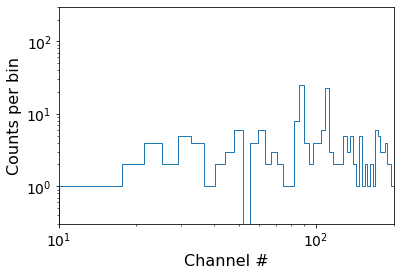

In [15]:
exp_data = np.genfromtxt('Giorgos_Zervas_Koukogias_EXP.dat')

nbins = 50
emin=10.0
emax=200.0
plt.figure()
counts, edges, patches = plt.hist(exp_data, bins=50, range=[emin,emax], density=False, histtype='step', fill=False)
plt.xlabel("Channel #", fontsize=16)
plt.ylabel("Counts per bin", fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.tick_params(labelsize=14)
plt.ylim(0.3,300.0)
plt.xlim(10.0,200.0)
plt.show()



In [16]:
#rebinning the same way we did the calibration experiments

nbins = 50
counts, edges = np.histogram(exp_data, bins=nbins, range=[emin,emax], density=False)
mincounts = 20 # Here we set it to our minimum requirement of 20
counts_new, edges_new = histrebin(mincounts,counts,edges)




bwidths = np.diff(edges_new) # calculates the width of each bin
cdens = counts_new/bwidths # determines the count densities
cdens_err = np.sqrt(counts_new)/bwidths



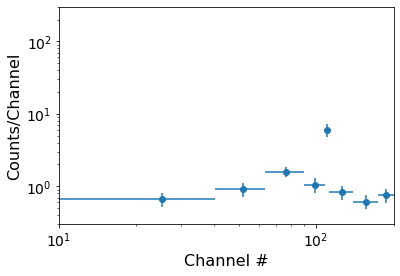

In [17]:
exp_data = (edges_new[:-1]+edges_new[1:])/2.  # This calculates the energy bin centres

plt.figure()
plt.errorbar(exp_data, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
plt.xlabel("Channel #", fontsize=16)
plt.ylabel("Counts/Channel", fontsize=16)
plt.tick_params(labelsize=14)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.3,300.0)
plt.xlim(10.0,200.0)
plt.show()      

[0.14710974 0.20099016 0.24363687 0.23537558 1.26206093 0.17633142
 0.13399344 0.16812541]


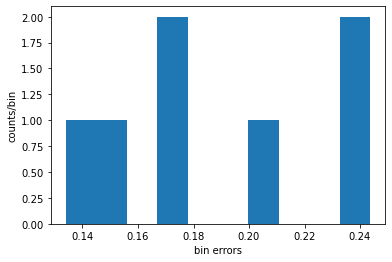

In [18]:
#quick plot to see whether the y-errosr are normally distributed
#for use in curve_fit
print(cdens_err)
cdens_errplot=np.delete(cdens_err, 4) #I just delete the outlier value for the sake of plotting instead of changing ylim

plt.figure()
plt.hist(cdens_errplot)
plt.xlabel('bin errors')
plt.ylabel('counts/bin')
plt.show()


# Model Fitting

## Single peak Gauss

In [19]:
p0_peak1 = [85.0, 5.0, 0.0,0.3]
model = gauss_model
ml_cfpars_peak1, ml_cfcovar_peak1 = spopt.curve_fit(lambda exp_data, *parm: model_int_cf(exp_data, edges_new, model, *parm),
                                        exp_data, cdens, p0_peak1, sigma=cdens_err)
best_model_peak1 = model_int_cf(exp_data, edges_new, model, *ml_cfpars_peak1)
minchisq_peak1 = np.sum(((cdens - best_model_peak1)/cdens_err)**2.)




err_peak1 = np.sqrt(np.diag(ml_cfcovar_peak1))
print("Minimum Chi-squared = " + str(minchisq_peak1) + " for " + str(len(cdens)-len(p0_peak1)) + " d.o.f.")
print("The goodness of fit is: " + str(scipy.stats.chi2.sf(minchisq_peak1,df=(len(cdens)-len(p0_peak1)))))



Minimum Chi-squared = 17.826941233819003 for 4 d.o.f.
The goodness of fit is: 0.0013339962851141203


## Single peak Gauss

In [20]:
p0_peak2 = [110.0, 5.0 , 0.0, 0.3]
model = gauss_model
ml_cfpars_peak2, ml_cfcovar_peak2 = spopt.curve_fit(lambda exp_data, *parm: model_int_cf(exp_data, edges_new, model, *parm),
                                        exp_data, cdens, p0_peak2, sigma=cdens_err)
best_model_peak2 = model_int_cf(exp_data, edges_new, model, *ml_cfpars_peak2)
minchisq_peak2 = np.sum(((cdens - best_model_peak2)/cdens_err)**2.)


err_peak2 = np.sqrt(np.diag(ml_cfcovar_peak2))
print("Minimum Chi-squared = " + str(minchisq_peak2) + " for " + str(len(cdens)-len(p0_peak2)) + " d.o.f.")
print("The goodness of fit is: " + str(scipy.stats.chi2.sf(minchisq_peak2,df=(len(cdens)-len(p0_peak2)))))

Minimum Chi-squared = 13.490678454737658 for 4 d.o.f.
The goodness of fit is: 0.009111226404989438


## Double peak Gauss

In [62]:
p0 = [85.0, 5.0, 0.0, 110.0, 5.0 , 0.0, 0.3]
model = double_gauss_model
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda exp_data, *parm: model_int_cf(exp_data, edges_new, model, *parm),
                                        exp_data, cdens, p0, sigma=cdens_err)
best_model = model_int_cf(exp_data, edges_new, model, *ml_cfpars)
minchisq = np.sum(((cdens - best_model)/cdens_err)**2.)

peak1_en=ml_cfpars[0]*r2[0] #using the calculated gain k(r2[0]) to get the energy equivalent
peak2_en=ml_cfpars[3]*r2[0]

err = np.sqrt(np.diag(ml_cfcovar))
print(err)
print("Covariance matrix:",ml_cfcovar)

print("Peak1_channel = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Peak1_width  = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Peak1_norm = " + str(ml_cfpars[2]) + " +/- " + str(err[2]))
print("Peak2_channel = " + str(ml_cfpars[3]) + " +/- " + str(err[3]))
print("Peak2_width = " + str(ml_cfpars[4]) + " +/- " + str(err[4]))
print("Peak2_norm = " + str(ml_cfpars[5]) + " +/- " + str(err[5]))
print("Peak1_energy = " + str(round((ml_cfpars[0])*r2[0],3)))
print("Peak2_energy = " + str(round((ml_cfpars[3])*r2[0],3)))


print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(scipy.stats.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

chi2 = sps.chi2(1)
print("p-value for our delta-chi-squared compared to peak 1 fit: ",chi2.sf(17.41))
print("p-value for our delta-chi-squared compared to peak 2 fit: ",chi2.sf(13.08))

[1.13531707e+07 1.31480774e+07 4.52937646e+02 5.06576745e+01
 2.95743988e+01 4.44847038e+02 6.73304951e-02]
Covariance matrix: [[ 1.28894484e+14  1.49272366e+14  5.14185928e+09  5.75094826e+08
  -3.35720425e+08 -5.04998705e+09 -4.42324590e+05]
 [ 1.49272366e+14  1.72871939e+14  5.95477385e+09  6.66015821e+08
  -3.88796950e+08 -5.84837685e+09 -5.12254967e+05]
 [ 5.14185928e+09  5.95477385e+09  2.05152511e+05  2.29418931e+04
  -1.33919547e+04 -2.01446745e+05 -1.77941798e+01]
 [ 5.75094826e+08  6.66015821e+08  2.29418931e+04  2.56619998e+03
  -1.49781706e+03 -2.25311825e+04 -1.97775061e+00]
 [-3.35720425e+08 -3.88796950e+08 -1.33919547e+04 -1.49781707e+03
   8.74645062e+02  1.31549932e+04  1.13982058e+00]
 [-5.04998705e+09 -5.84837685e+09 -2.01446745e+05 -2.25311825e+04
   1.31549932e+04  1.97888887e+05  1.71809741e+01]
 [-4.42324574e+05 -5.12254963e+05 -1.77941792e+01 -1.97775057e+00
   1.13982055e+00  1.71809737e+01  4.53339558e-03]]
Peak1_channel = 66.79876491269768 +/- 11353170.654595

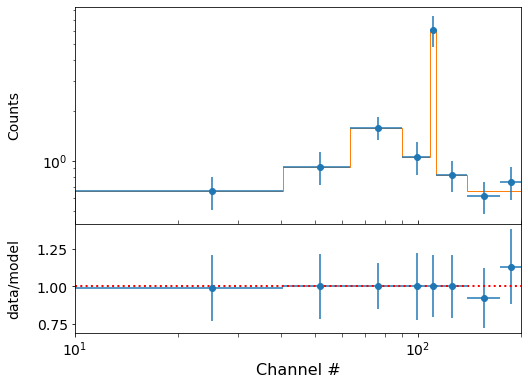

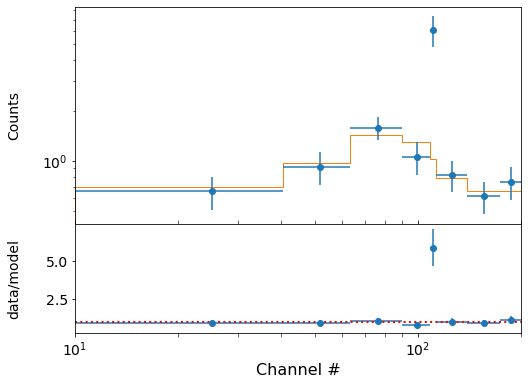

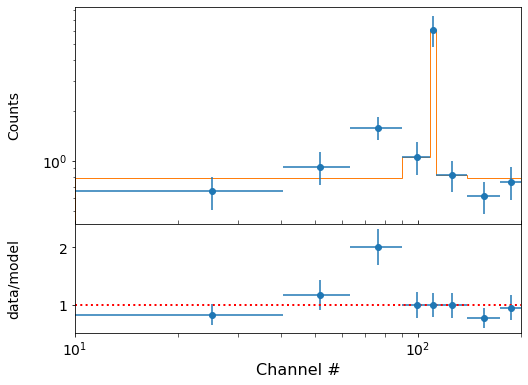

In [22]:
plot_spec_model(exp_data,cdens,cdens_err,best_model,edges_new)
plot_spec_model(exp_data,cdens,cdens_err,best_model_peak1,edges_new)
plot_spec_model(exp_data,cdens,cdens_err,best_model_peak2,edges_new)

In [28]:
print(peak1_en)
print(peak2_en)

gmeannn=gmean([peak1_en,peak2_en])
print(gmeannn)

75.13779173021604
124.09831314448151
96.56331191048281


# Confidence intervals

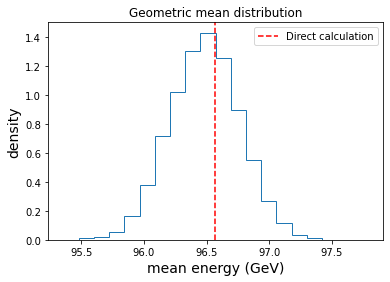

The distribution of the geometric means for 10.000 trials of 100 sample size each, using the values generated by our model fitting
it approaches a normal distribution with mean: 96.48551219688608 and standard deviation: 0.27905595665342886
68% confidence interval: (96.20800280093543, 96.76302159283672)
95% confidence interval: (95.93857257217398, 97.03245182159817)
99.7% confidence interval: (95.65734725103316, 97.31367714273898)


In [45]:
ntrials = np.geomspace(10,1e5,10000,dtype=int) #number of trials

# Set up the array to record the differences
g_mean = np.zeros(len(ntrials))

for i, N in enumerate(ntrials):
   
    x1 = sps.norm.rvs(loc=peak1_en,scale=ml_cfpars[1],size=(100)) #drawing samples of size 100 from normal distributions of 
    x2 = sps.norm.rvs(loc=peak2_en,scale=ml_cfpars[4],size=(100)) #mu and sigma equal to the ones estimated by the model
    g_mean[i] = np.sqrt(gmean(x1*x2))  #then calculating the geometric mean for each sample
   
plt.figure()
dens, edges, patches = plt.hist(g_mean, bins=20, density=True, histtype='step')
plt.axvline(x=gmeannn, linestyle='--' , color='r', label='Direct calculation')
plt.xlabel('mean energy (GeV)',fontsize=14)
plt.title('Geometric mean distribution')
plt.legend(loc=1)
plt.ylabel('density',fontsize=14)

plt.show()
print('The distribution of the geometric means for 10.000 trials of 100 sample size each, using the values generated by our model fitting')
print('it approaches a normal distribution with mean:',np.mean(g_mean), 'and standard deviation:', np.std(g_mean))
print('68% confidence interval:', (sps.norm.interval(0.68,loc=np.mean(g_mean),scale=np.std(g_mean))))
print('95% confidence interval:', sps.norm.interval(0.95,loc=np.mean(g_mean),scale=np.std(g_mean)))
print('99.7% confidence interval:', sps.norm.interval(0.997,loc=np.mean(g_mean),scale=np.std(g_mean)))